In [ ]:
!pip install groq
!pip install tavily-python

In [ ]:
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

## 使用Tool-Use

In [ ]:
# 导入所需的库
from groq import Groq  # 导入Groq API客户端
import json  # 用于JSON数据处理
import os  # 用于环境变量操作
import pprint

# 初始化Groq客户端，使用环境变量中的API密钥
client = Groq(
    api_key = os.environ.get("GROQ_API_KEY"),
)

# 定义使用的模型名称
MODEL = 'llama3-groq-70b-8192-tool-use-preview'

def calculate(expression):
    """计算数学表达式"""
    try:
        # 使用eval函数评估表达式
        result = eval(expression)
        # 返回JSON格式的结果
        return json.dumps({"result": result})
    except:
        # 如果计算出错，返回错误信息
        return json.dumps({"error": "Invalid expression"})

def run_conversation(user_prompt):
    # 定义对话的消息列表
    messages=[
        {
            "role": "system",
            "content": "你是一个计算器助手。使用计算函数执行数学运算并提供结果."
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]

    # 定义可用的工具（函数）
    tools = [
        {
            "type": "function",
            "function": {
                "name": "calculate",
                "description": "计算数学表达式",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "expression": {
                            "type": "string",
                            "description": "要评估的数学表达式",
                        }
                    },
                    "required": ["expression"],
                },
            },
        }
    ]

    print('第一次信息输出 \n')
    print(messages)
    print('\n')


    # 发送第一次请求到Groq API

    # 作用和目的：
    # 初始化对话：将用户的问题发送给 AI 模型。
    # 提供工具信息：告诉模型可以使用哪些工具（在这里是 calculate 函数）。
    # 获取模型的初步响应：模型可能会直接回答，或者决定使用提供的工具。

    # 特点：
    # 包含了初始的对话历史（系统提示和用户问题）。
    # 提供了 tools 参数，定义了可用的函数。
    # 使用 tool_choice="auto"，允许模型自主决定是否使用工具。
    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools,
        tool_choice="auto",
        max_tokens=4096
    )

    print('\n')
    print('输出response \n')
    print(response)
    print('\n')


    # 获取响应消息和工具调用
    response_message = response.choices[0].message
    print('\n')
    print('第一次响应输出 \n')
    print(response_message)
    print('\n')


    tool_calls = response_message.tool_calls
    print('输出tool_calls信息: \n')
    pprint.pprint(tool_calls)
    print('\n')



    # 如果有工具调用
    if tool_calls:
        # 定义可用的函数字典
        available_functions = {
            "calculate": calculate,
        }
        # 将响应消息添加到对话历史
        messages.append(response_message)

        # 处理每个工具调用
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            # 解析函数参数
            function_args = json.loads(tool_call.function.arguments)
            # 调用函数并获取响应
            function_response = function_to_call(
                expression=function_args.get("expression")
            )
            print('\n输出function_response '+function_response +'\n')
            # 将函数调用结果添加到对话历史
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            )

        print('第二次信息输出 \n')
        print(messages)
        print('\n')



        # 发送第二次请求到Groq API，包含函数调用结果

        # 作用和目的：
        # 处理工具调用的结果：将计算结果反馈给模型。
        # 获取最终响应：让模型基于计算结果生成人类可读的回答。

        # 特点：
        # 包含了更新后的对话历史，包括第一次响应和工具调用的结果。
        # 没有提供 tools 参数，因为此时不需要再次使用工具。
        # 目的是获取最终的、格式化的回答。
        second_response = client.chat.completions.create(
            model=MODEL,
            messages=messages
        )
        # 返回最终响应内容
        return second_response.choices[0].message.content

# 定义用户提示
user_prompt = "计算25.6602988 * 4/0.259484 + 5.69560456 -398.11287180等于多少?这个数字有什么特殊意义吗?用中文回答."

# user_prompt = "1+1 等于多少?"

# 运行对话并打印结果
print('第二次响应输出 \n'+run_conversation(user_prompt))

第一次信息输出 

[{'role': 'system', 'content': '你是一个计算器助手。使用计算函数执行数学运算并提供结果.'}, {'role': 'user', 'content': '计算25.6602988 * 4/0.259484 + 5.69560456 -398.11287180等于多少?这个数字有什么特殊意义吗?用中文回答.'}]




输出response 

ChatCompletion(id='chatcmpl-ba6b7cab-44b1-4cd5-87ea-b973aa5fe5e9', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_c5n2', function=Function(arguments='{"expression": "25.6602988 * 4/0.259484 + 5.69560456 -398.11287180"}', name='calculate'), type='function')]))], created=1721531799, model='llama3-groq-70b-8192-tool-use-preview', object='chat.completion', system_fingerprint='fp_ee4b521143', usage=CompletionUsage(completion_tokens=50, prompt_tokens=253, total_tokens=303, completion_time=0.155088747, prompt_time=0.018514899, queue_time=None, total_time=0.173603646), x_groq={'id': 'req_01j39mn62sf4xr1svrpbas27yc'})




第一次响应输出 

ChatCompletionM

## 执行流程

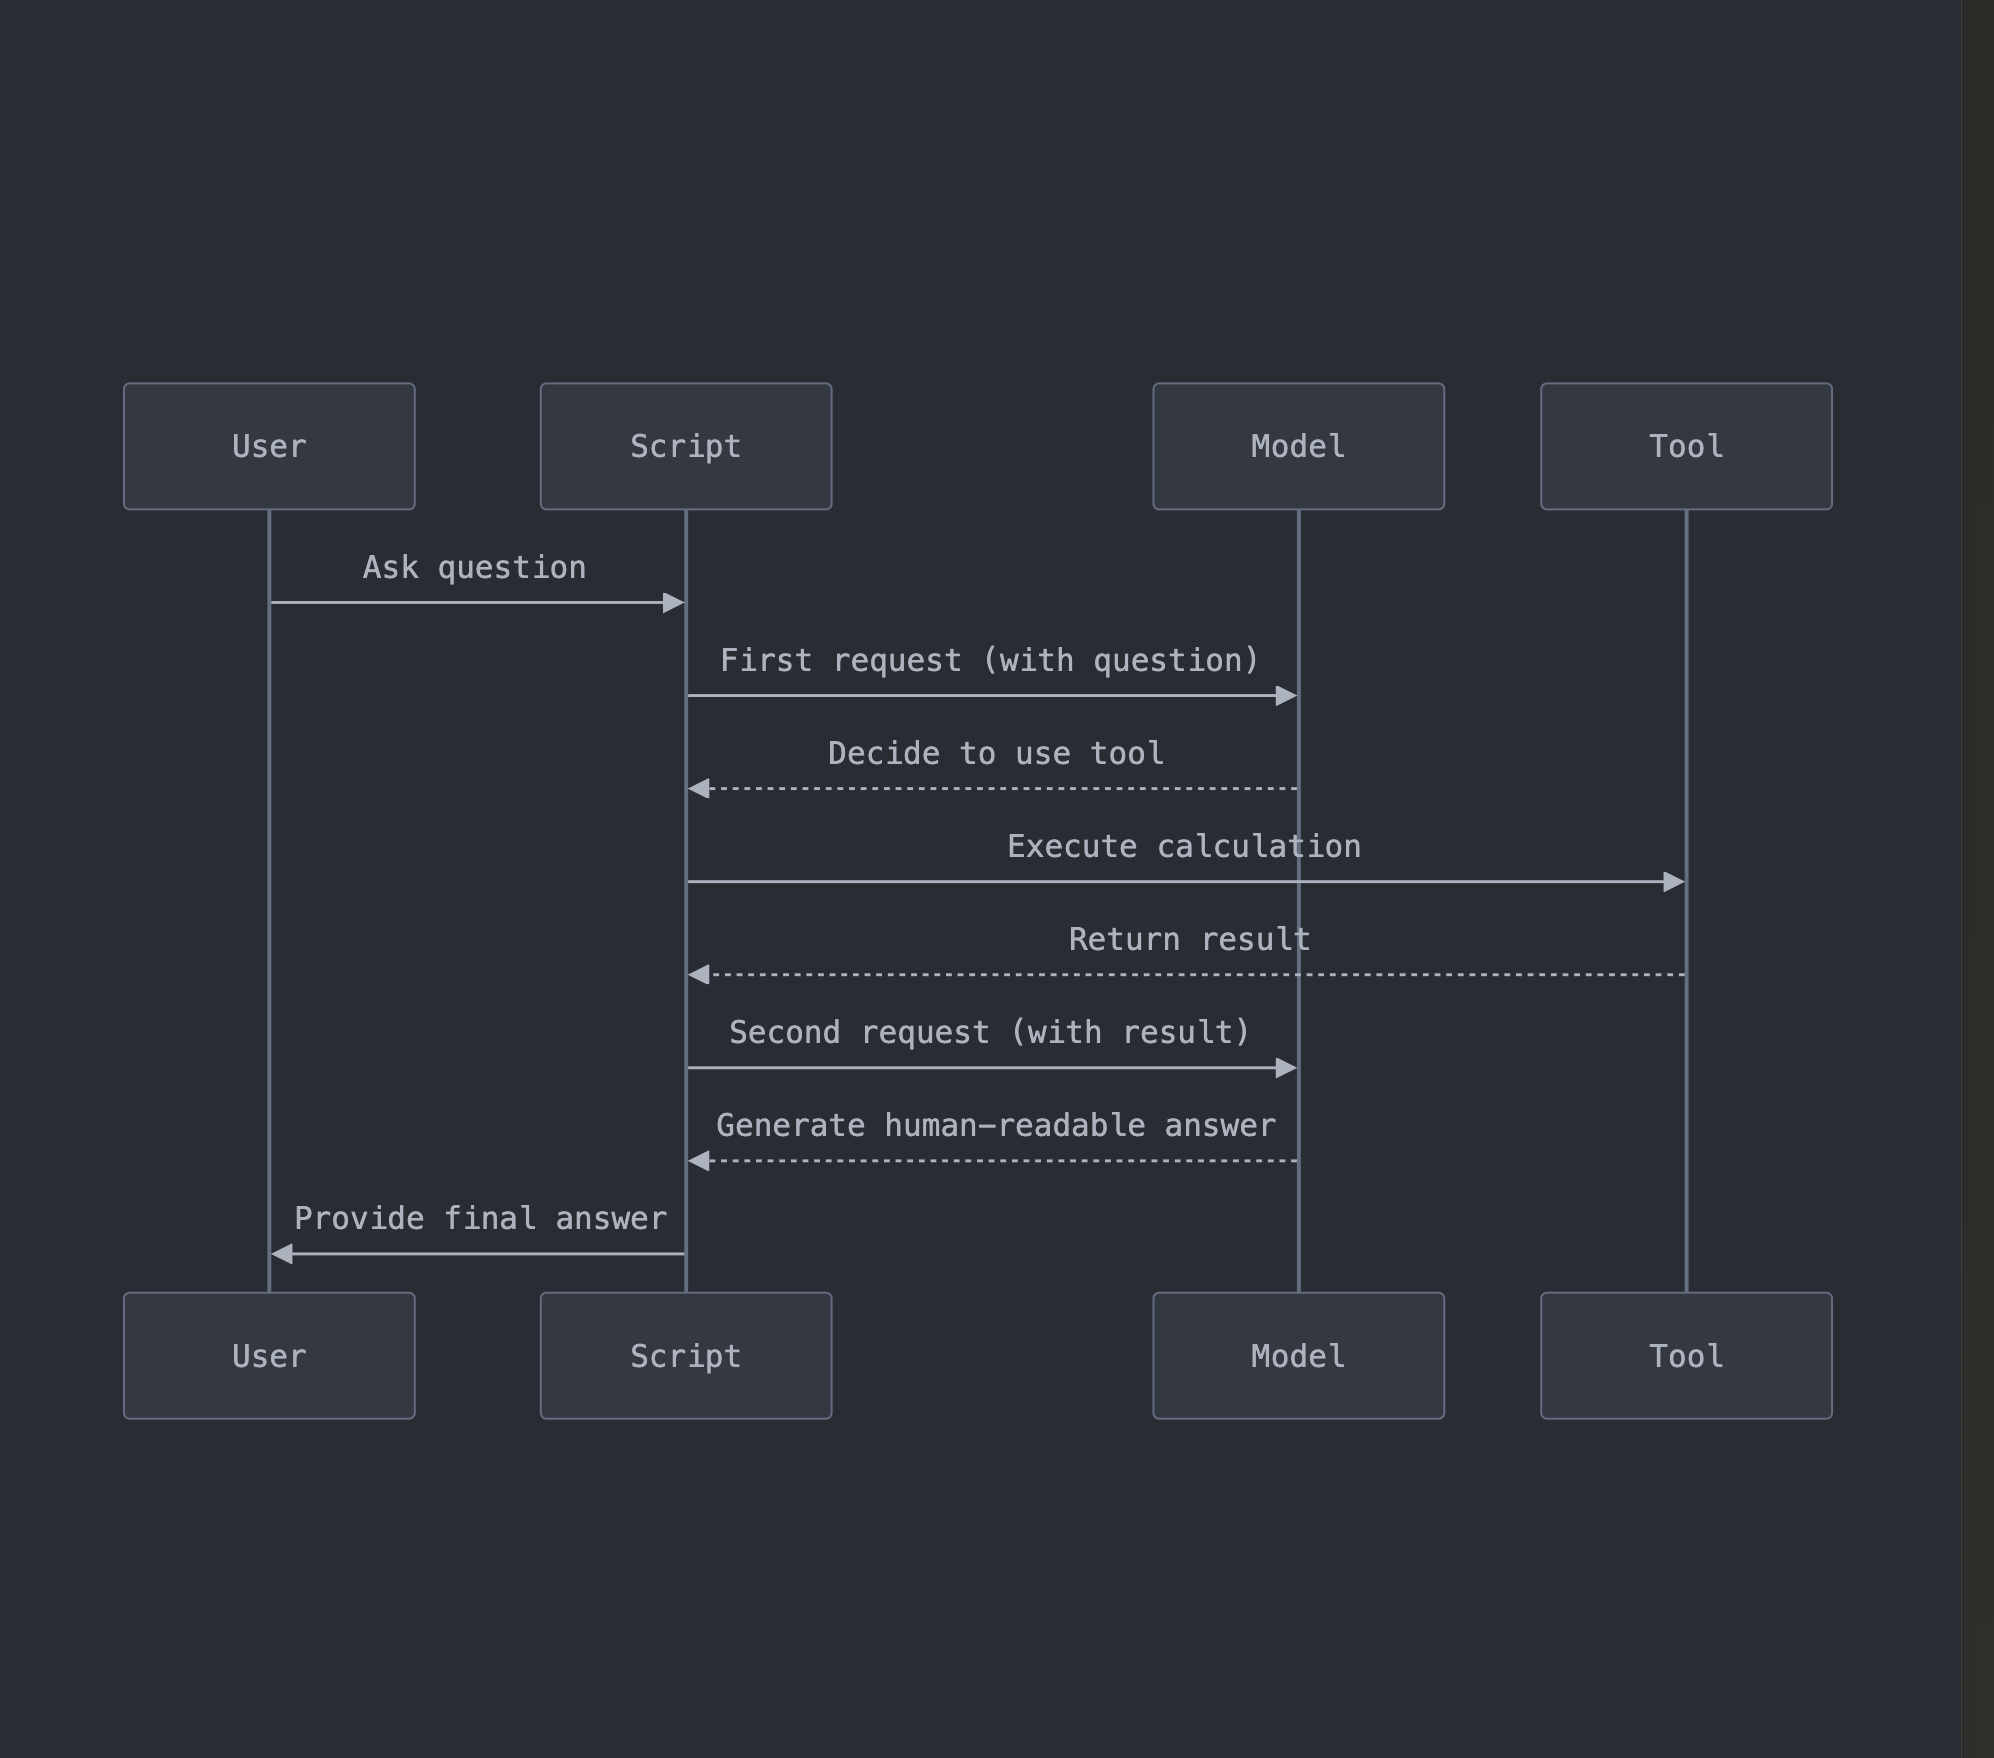

### 不使用Tool-Use，直接调用API

In [ ]:
from groq import Groq
import os

client = Groq(
    api_key = os.environ.get("GROQ_API_KEY"),
)

MODEL = 'llama3-groq-70b-8192-tool-use-preview'

def run_conversation(user_prompt):
    messages = [
        {
            "role": "system",
            "content": "你是一个计算器助手。你需要理解用户的数学问题，进行计算，并提供详细的步骤和最终结果。请确保你的计算是准确的。"
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        max_tokens=4096
    )

    return response.choices[0].message.content

user_prompt = "计算25.6602988 * 4/0.259484 + 5.69560456689 -398.112871804等于多少?这个数字有什么特殊意义吗?用中文回答."

print(run_conversation(user_prompt))

Let's solve this step by step:

1. Multiply 25.6602988 by 4: 25.6602988 * 4 = 102.6411952
2. Divide the result by 0.259484: 102.6411952 / 0.259484 ≈ 395.233
3. Add 5.69560456689 to the result: 395.233 + 5.69560456689 ≈ 400.928
4. Subtract 398.112871804 from the result: 400.928 - 398.112871804 ≈ 2.815

So, the result of the calculation is approximately 2.815.

This number doesn't have any special significance in general. It's just the result of the given mathematical operations.


In [ ]:

import sqlite3
import random
from datetime import datetime, timedelta

# 连接到SQLite数据库（如果不存在则创建）
conn = sqlite3.connect('demo_users.db')
cursor = conn.cursor()

# 创建用户表
cursor.execute('''
CREATE TABLE IF NOT EXISTS users (
    id INTEGER PRIMARY KEY,
    name TEXT NOT NULL,
    age INTEGER,
    email TEXT UNIQUE,
    registration_date DATE,
    last_login DATETIME
)
''')

# 生成示例数据
names = ["Alice", "Bob", "Charlie", "David", "Eva", "Frank", "Grace", "Henry", "Ivy", "Jack"]
domains = ["gmail.com", "yahoo.com", "hotmail.com", "example.com"]

for i in range(50):  # 创建50个用户记录
    name = random.choice(names)
    age = random.randint(18, 70)
    email = f"{name.lower()}{random.randint(1, 100)}@{random.choice(domains)}"
    registration_date = datetime.now() - timedelta(days=random.randint(1, 1000))
    last_login = registration_date + timedelta(days=random.randint(1, 500))

    cursor.execute('''
    INSERT INTO users (name, age, email, registration_date, last_login)
    VALUES (?, ?, ?, ?, ?)
    ''', (name, age, email, registration_date.date(), last_login))

# 提交更改并关闭连接
conn.commit()
conn.close()

print("Demo database 'demo_users.db' created successfully with sample data.")

# 函数用于显示表格内容
def display_table_contents():
    conn = sqlite3.connect('demo_users.db')
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM users LIMIT 5")
    rows = cursor.fetchall()

    print("\nSample data from the users table:")
    for row in rows:
        print(row)

    conn.close()

display_table_contents()

Demo database 'demo_users.db' created successfully with sample data.

Sample data from the users table:
(1, 'Frank', 60, 'frank4@hotmail.com', '2022-05-16', '2022-11-03 03:26:33.612433')
(2, 'Ivy', 44, 'ivy65@gmail.com', '2022-11-12', '2022-12-18 03:26:33.612729')
(3, 'Frank', 31, 'frank30@gmail.com', '2022-11-27', '2024-02-13 03:26:33.612762')
(4, 'Charlie', 52, 'charlie53@hotmail.com', '2023-02-12', '2024-03-26 03:26:33.612779')
(5, 'Alice', 21, 'alice48@yahoo.com', '2022-06-29', '2022-09-29 03:26:33.612794')


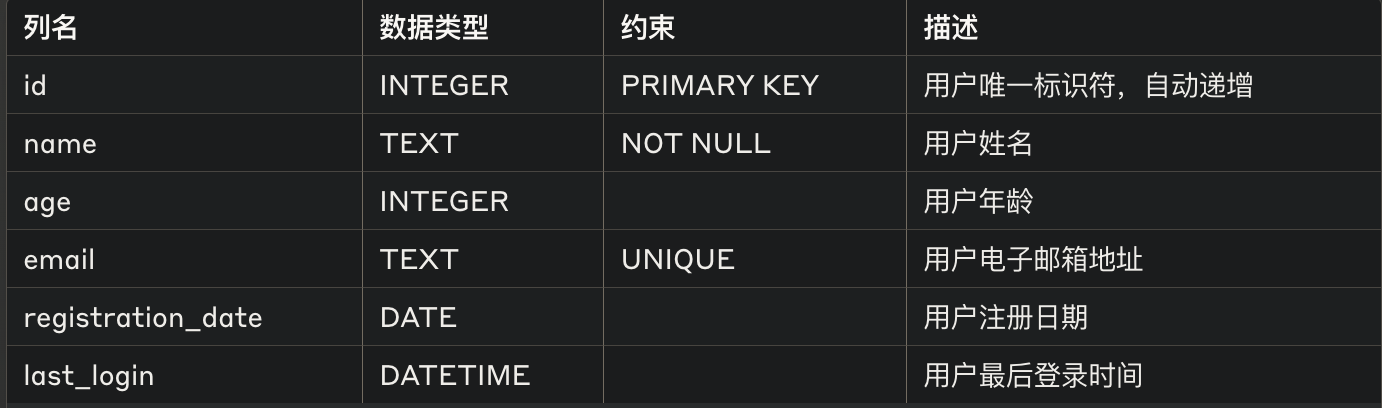

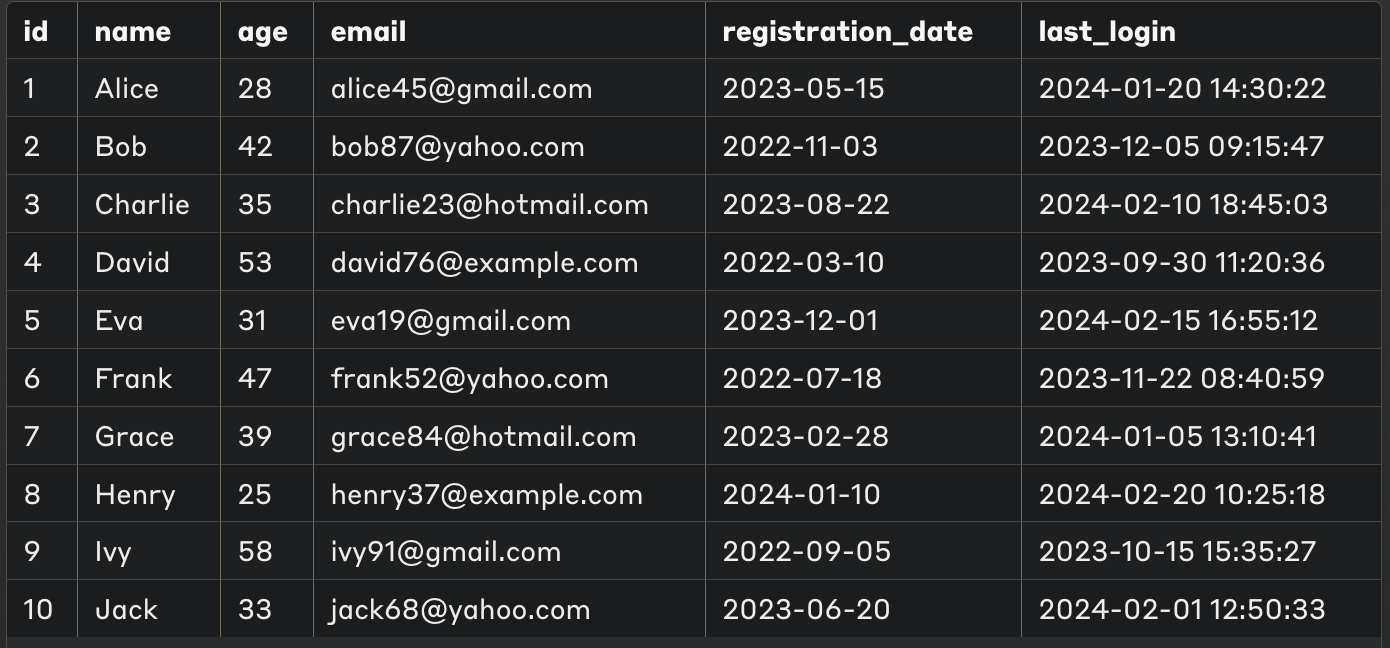

In [ ]:

import os
import json
import sqlite3
from groq import Groq
from datetime import datetime, timedelta

# 初始化Groq客户端
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# 数据库连接函数
def get_db_connection():
    """创建并返回到SQLite数据库的连接"""
    conn = sqlite3.connect('demo_users.db')
    conn.row_factory = sqlite3.Row
    return conn

def execute_sql(sql_query):
    """执行SQL查询并返回结果"""
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute(sql_query)
        results = [dict(row) for row in cursor.fetchall()]
        return results
    except sqlite3.Error as e:
        return f"数据库错误: {e}"
    finally:
        conn.close()

def generate_sql(table_info, conditions, select_fields="*"):
    """
    生成SQL查询
    :param table_info: 表信息
    :param conditions: WHERE子句的条件
    :param select_fields: 要选择的字段，默认为所有字段
    :return: 生成的SQL查询字符串
    """
    return f"SELECT {select_fields} FROM users WHERE {conditions}"

def format_results(results, fields=None):
    """
    格式化查询结果
    :param results: 查询返回的结果列表
    :param fields: 要显示的字段列表，如果为None则显示所有字段
    :return: 格式化后的结果字符串
    """
    if isinstance(results, str):  # 如果结果是错误消息
        return results

    if not results:
        return "没有找到匹配的记录。"

    if fields:
        formatted = [", ".join(str(row.get(field, "N/A")) for field in fields) for row in results]
    else:
        formatted = [json.dumps(row, ensure_ascii=False, indent=2) for row in results]

    return "\n".join(formatted)

def run_text2sql_conversation(user_prompt):
    """
    运行text2sql对话
    :param user_prompt: 用户输入的查询
    :return: 查询结果
    """
    table_info = "users(id INTEGER, name TEXT, age INTEGER, email TEXT, registration_date DATE, last_login DATETIME)"

    messages = [
        {
            "role": "system",
            "content": f"你是一个SQL助手。使用generate_sql函数根据用户请求创建SQL查询。可用的表: {table_info}。准确理解用户需求，包括他们想要查询的具体字段。"
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]

    tools = [
        {
            "type": "function",
            "function": {
                "name": "generate_sql",
                "description": "根据用户请求生成SQL查询",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "table_info": {
                            "type": "string",
                            "description": "表结构信息",
                        },
                        "conditions": {
                            "type": "string",
                            "description": "WHERE子句的具体查询条件",
                        },
                        "select_fields": {
                            "type": "string",
                            "description": "要选择的字段，用逗号分隔",
                        }
                    },
                    "required": ["table_info", "conditions", "select_fields"],
                },
            },
        }
    ]

    try:
        response = client.chat.completions.create(
            model="llama3-groq-70b-8192-tool-use-preview",
            messages=messages,
            tools=tools,
            tool_choice="auto",
            max_tokens=4096
        )

        assistant_message = response.choices[0].message

        if assistant_message.tool_calls:
            for tool_call in assistant_message.tool_calls:
                if tool_call.function.name == "generate_sql":
                    function_args = json.loads(tool_call.function.arguments)
                    sql_query = generate_sql(
                        function_args["table_info"],
                        function_args["conditions"],
                        function_args["select_fields"]
                    )
                    results = execute_sql(sql_query)
                    formatted_results = format_results(results, function_args["select_fields"].split(", ") if function_args["select_fields"] != "*" else None)
                    return f"生成的SQL查询: {sql_query}\n\n结果:\n{formatted_results}"

        return "无法生成SQL查询。请尝试重新表述您的问题。"

    except Exception as e:
        return f"发生错误: {str(e)}"

# 主程序
if __name__ == "__main__":
    print("欢迎使用Text2SQL系统！")
    print("您可以用自然语言询问有关用户表的问题。")
    print("输入'quit'退出程序。")

    while True:
        user_input = input("\n请输入您的查询 (或 'quit' 退出): ")
        if user_input.lower() == 'quit':
            print("谢谢使用，再见！")
            break

        result = run_text2sql_conversation(user_input)
        print("\n" + "="*50)
        print(result)
        print("="*50)

欢迎使用Text2SQL系统！
您可以用自然语言询问有关用户表的问题。
输入'quit'退出程序。

请输入您的查询 (或 'quit' 退出): 查询Frank的年龄

生成的SQL查询: SELECT age FROM users WHERE name = 'Frank'

结果:
60
31
67
61
21

请输入您的查询 (或 'quit' 退出): 有几个叫Frank的人

生成的SQL查询: SELECT name FROM users WHERE name = 'Frank'

结果:
Frank
Frank
Frank
Frank
Frank


KeyboardInterrupt: Interrupted by user

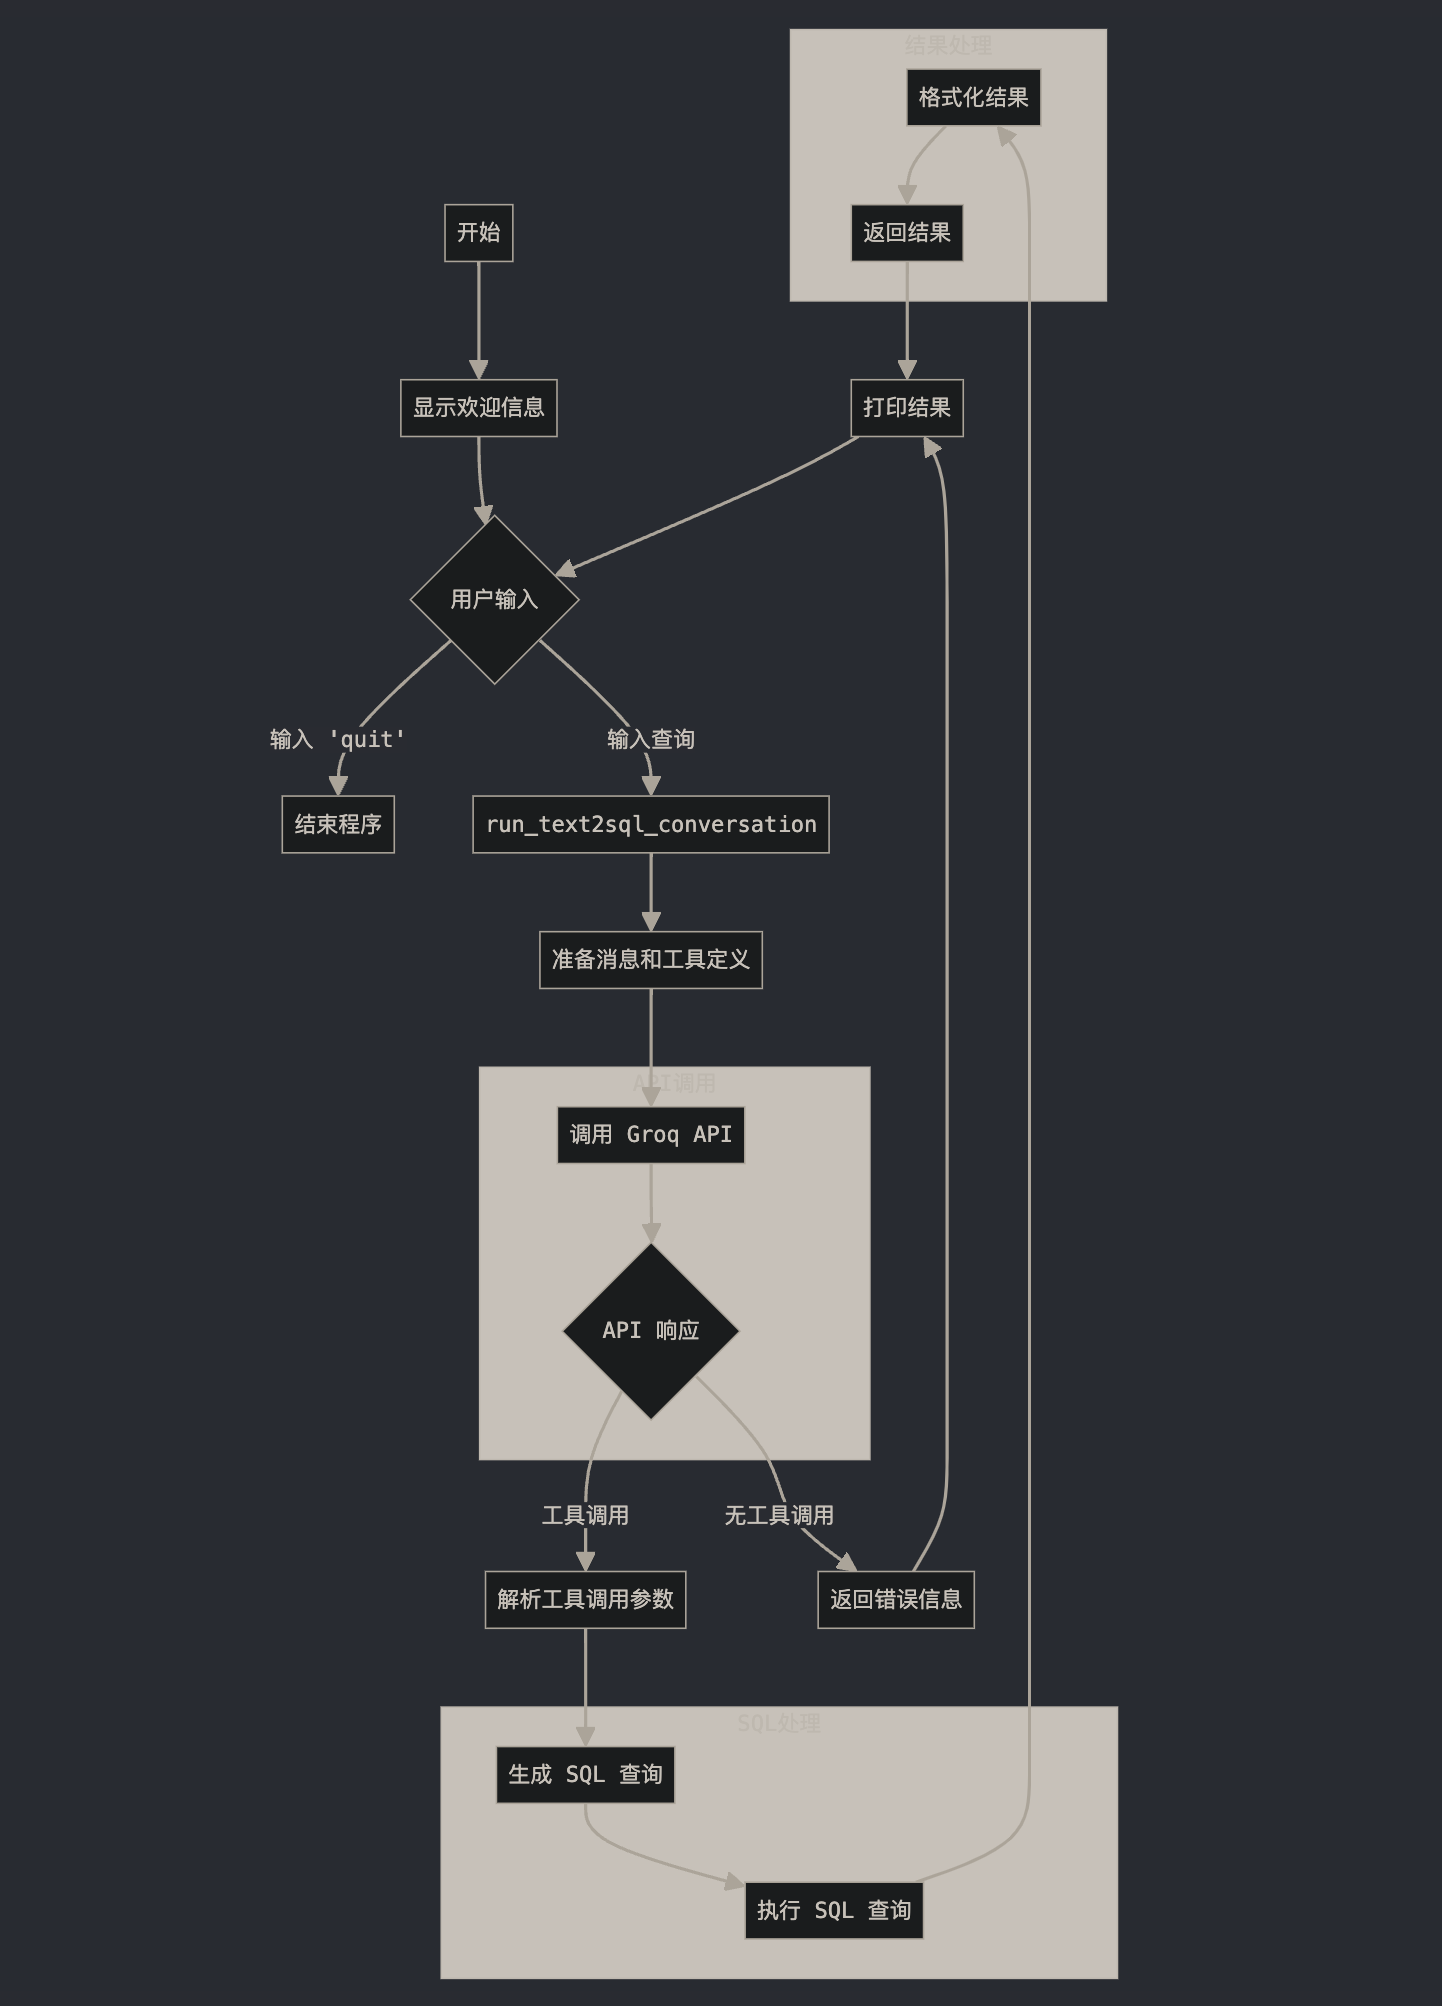

In [ ]:
# 导入所需的库
from groq import Groq
from tavily import TavilyClient
import json
import os
import pprint

# 初始化Groq客户端和Tavily客户端，使用环境变量中的API密钥
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
tavily_client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

# 定义使用的模型名称
MODEL = 'llama3-groq-70b-8192-tool-use-preview'

def tavily_search(query):
    """执行Tavily搜索"""
    try:
        response = tavily_client.search(query)
        # 返回前5个结果的标题、URL和内容摘要
        results = [{
            "title": r["title"],
            "url": r["url"],
            "content": r["content"][:200] + "..."  # 限制内容长度
        } for r in response["results"][:5]]
        return json.dumps({"results": results})
    except Exception as e:
        return json.dumps({"error": str(e)})

def run_conversation(user_prompt):
    messages = [
        {
            "role": "system",
            "content": "你是一个智能助手，能够进行在线搜索以回答问题。使用tavily_search函数来获取最新、最相关的信息。请基于搜索结果提供详细、准确的回答，并在适当的时候引用信息来源。"
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]

    tools = [
        {
            "type": "function",
            "function": {
                "name": "tavily_search",
                "description": "执行在线搜索查询，获取最新信息",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "query": {
                            "type": "string",
                            "description": "搜索查询",
                        }
                    },
                    "required": ["query"],
                },
            },
        }
    ]

    print('初始消息:\n')
    pprint.pprint(messages)
    print('\n')

    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools,
        tool_choice="auto",
        max_tokens=4096
    )

    print('Groq API 响应:\n')
    pprint.pprint(response)
    print('\n')

    response_message = response.choices[0].message
    print('AI 初始响应:\n')
    pprint.pprint(response_message)
    print('\n')

    tool_calls = response_message.tool_calls
    if tool_calls:
        print('工具调用信息:\n')
        pprint.pprint(tool_calls)
        print('\n')

        messages.append(response_message)

        for tool_call in tool_calls:
            function_args = json.loads(tool_call.function.arguments)
            function_response = tavily_search(**function_args)
            print(f'\nTavily 搜索响应:\n{function_response}\n')
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": "tavily_search",
                    "content": function_response,
                }
            )

        print('更新后的消息:\n')
        pprint.pprint(messages)
        print('\n')

        second_response = client.chat.completions.create(
            model=MODEL,
            messages=messages
        )
        return second_response.choices[0].message.content
    else:
        return response_message.content

# 用户提示示例
user_prompt = "今天有哪些新闻?"

# 运行对话并打印结果
print('最终AI响应:\n' + run_conversation(user_prompt))

初始消息:

[{'content': '你是一个智能助手，能够进行在线搜索以回答问题。使用tavily_search函数来获取最新、最相关的信息。请基于搜索结果提供详细、准确的回答，并在适当的时候引用信息来源。',
  'role': 'system'},
 {'content': '今天有哪些新闻?', 'role': 'user'}]


Groq API 响应:

ChatCompletion(id='chatcmpl-036e87dd-b8d6-4664-ad6b-e83d047f3502', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vra8', function=Function(arguments='{"query": "today\'s news"}', name='tavily_search'), type='function'), ChatCompletionMessageToolCall(id='call_vxhh', function=Function(arguments='{"query": "latest news"}', name='tavily_search'), type='function')]))], created=1721533023, model='llama3-groq-70b-8192-tool-use-preview', object='chat.completion', system_fingerprint='fp_ee4b521143', usage=CompletionUsage(completion_tokens=59, prompt_tokens=249, total_tokens=308, completion_time=0.185717451, prompt_time=0.018957092, queue_time=None, total_time